## Model combining Facenet and VGG in Keras

Pretrained Facenet model: https://github.com/nyoki-mtl/keras-facenet  
Pretrained VGG Face model: https://github.com/rcmalli/keras-vggface

In [20]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from imageio import imread
from skimage.transform import resize
from keras.models import load_model
import pandas as pd
from tqdm import tqdm

In [21]:
print(os.listdir("../input"))

['recognizing-faces-in-the-wild', 'facenet-keras']


In [22]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-mkmpsqgl
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-mkmpsqgl
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=4d46cd3e14e61585fc1157429150f3f594277883642c328b81148a3b0b855c2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-y08gbesk/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
import h5py
from collections import defaultdict
from glob import glob
from random import choice, sample

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D, Lambda, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace

In [24]:
train_file_path = "../input/recognizing-faces-in-the-wild/train_relationships.csv"
train_folders_path = "./train/"
val_families = "F09"  # the validataion famliy

In [25]:
# unzip trian and test data
!unzip -q ../input/recognizing-faces-in-the-wild/train.zip -d train
!unzip -q ../input/recognizing-faces-in-the-wild/test.zip -d test

replace train/F0680/MID4/P07102_face3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
replace test/face00111.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [26]:
all_images = glob(train_folders_path + "*/*/*.jpg")
print(all_images[0])

./train/F0596/MID4/P10684_face1.jpg


In [27]:
# split train data set and validataion dataset
train_images = [x for x in all_images if val_families not in x]
val_images = [x for x in all_images if val_families in x]

In [28]:
ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
print(ppl[0])
print(len(ppl))

F0596/MID4
12379


In [29]:
# map from the person name to image map
train_person_to_images_map = defaultdict(list)

for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)

for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]

train = [x for x in relationships if val_families not in x[0]]
val = [x for x in relationships if val_families in x[0]]

In [30]:
# preprocess the image, improve the brightness (gamma correction)
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

In [31]:
# model path of the final model
model_path = '../input/facenet-keras/facenet_keras.h5'
model_fn = load_model(model_path)

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [32]:
# change the learnable parameters of facenet to trainable
for layer in model_fn.layers[:-3]:
    layer.trainable = True

In [33]:
# change the learnable parameters of facenet to trainable
model_vgg = VGGFace(model='resnet50', include_top=False)
for layer in model_vgg.layers[:-3]:
    layer.trainable = True

In [34]:
# image size of facenet and VGG
IMG_SIZE_FN = 160
IMG_SIZE_VGG = 224

In [35]:
# read and resize the images for facenet
def read_img_fn(path):
    img = cv2.imread(path)
    img = cv2.resize(img,(IMG_SIZE_FN,IMG_SIZE_FN))
    img = np.array(img).astype(np.float)
    return prewhiten(img)

# read and resize the images for VGG
def read_img_vgg(path):
    img = cv2.imread(path)
    img = cv2.resize(img,(IMG_SIZE_VGG,IMG_SIZE_VGG))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)


# generate training data, used balance generation
def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1_FN = np.array([read_img_fn(x) for x in X1])
        X1_VGG = np.array([read_img_vgg(x) for x in X1])

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2_FN = np.array([read_img_fn(x) for x in X2])
        X2_VGG = np.array([read_img_vgg(x) for x in X2])

        yield [X1_FN, X2_FN, X1_VGG, X2_VGG], labels


In [36]:
def signed_sqrt(x):
    return K.sign(x)*K.sqrt(K.abs(x)+1e-9)

In [37]:
def baseline_model():
    input_1 = Input(shape=(IMG_SIZE_FN, IMG_SIZE_FN, 3))
    input_2 = Input(shape=(IMG_SIZE_FN, IMG_SIZE_FN, 3))
    input_3 = Input(shape=(IMG_SIZE_VGG, IMG_SIZE_VGG, 3))
    input_4 = Input(shape=(IMG_SIZE_VGG, IMG_SIZE_VGG, 3))

    x1 = model_fn(input_1)
    x2 = model_fn(input_2)
    x3 = model_vgg(input_3)
    x4 = model_vgg(input_4)
    
    x1 = Reshape((1, 1 ,128))(x1)
    x2 = Reshape((1, 1 ,128))(x2)
    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x1t = Lambda(lambda tensor  : K.square(tensor))(x1)
    x2t = Lambda(lambda tensor  : K.square(tensor))(x2)
    x3t = Lambda(lambda tensor  : K.square(tensor))(x3)
    x4t = Lambda(lambda tensor  : K.square(tensor))(x4)
    
    merged_add_fn = Add()([x1, x2])
    merged_add_vgg = Add()([x3, x4])
    merged_sub1_fn = Subtract()([x1,x2])
    merged_sub1_vgg = Subtract()([x3,x4])
    merged_sub2_fn = Subtract()([x2,x1])
    merged_sub2_vgg = Subtract()([x4,x3])
    merged_mul1_fn = Multiply()([x1,x2])
    merged_mul1_vgg = Multiply()([x3,x4])
    merged_sq1_fn = Add()([x1t,x2t])
    merged_sq1_vgg = Add()([x3t,x4t])
    merged_sqrt_fn = Lambda(lambda tensor  : signed_sqrt(tensor))(merged_mul1_fn)
    merged_sqrt_vgg = Lambda(lambda tensor  : signed_sqrt(tensor))(merged_mul1_vgg)


    merged_add_vgg = Conv2D(128 , [1,1] )(merged_add_vgg)
    merged_sub1_vgg = Conv2D(128 , [1,1] )(merged_sub1_vgg)
    merged_sub2_vgg = Conv2D(128 , [1,1] )(merged_sub2_vgg)
    merged_mul1_vgg = Conv2D(128 , [1,1] )(merged_mul1_vgg)
    merged_sq1_vgg = Conv2D(128 , [1,1] )(merged_sq1_vgg)
    merged_sqrt_vgg = Conv2D(128 , [1,1] )(merged_sqrt_vgg)
    
    # merge features
    merged = Concatenate(axis=-1)([Flatten()(merged_add_vgg), (merged_add_fn), Flatten()(merged_sub1_vgg), (merged_sub1_fn),
                                   Flatten()(merged_sub2_vgg), (merged_sub2_fn), Flatten()(merged_mul1_vgg), (merged_mul1_fn), 
                                   Flatten()(merged_sq1_vgg), (merged_sq1_fn), Flatten()(merged_sqrt_vgg), (merged_sqrt_fn)])

    merged = Dense(100, activation="relu")(merged)
    merged = Dropout(0.1)(merged)
    merged = Dense(25, activation="relu")(merged)
    merged = Dropout(0.1)(merged)
    out = Dense(1, activation="sigmoid")(merged)

    model = Model([input_1, input_2, input_3, input_4], out)

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    model.summary()

    return model


file_path = "facenet_vgg.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = baseline_model() 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
inception_

In [38]:
history = model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=120, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/120
200/200 [==============================] - 250s 1s/step - loss: 1.7427 - acc: 0.5141 - val_loss: 1.3987 - val_acc: 0.5319

Epoch 00001: val_acc improved from -inf to 0.53187, saving model to facenet_vgg.h5
Epoch 2/120
200/200 [==============================] - 147s 736ms/step - loss: 0.8436 - acc: 0.5606 - val_loss: 1.0001 - val_acc: 0.5425

Epoch 00002: val_acc improved from 0.53187 to 0.54250, saving model to facenet_vgg.h5
Epoch 3/120
200/200 [==============================] - 148s 741ms/step - loss: 0.7361 - acc: 0.5622 - val_loss: 0.7650 - val_acc: 0.5431

Epoch 00003: val_acc improved from 0.54250 to 0.54312, saving model to facenet_vgg.h5
Epoch 4/120
200/200 [==============================] - 148s 738ms/step - loss: 0.7056 - acc: 0.5772 - val_loss: 0.7247 - val_acc: 0.5675

Epoch 00004: val_acc improved from 0.54312 to 0.56750, saving model to facenet_vgg.h5
Epoch 5/120
200/200 [==============================] - 147s 736ms/step - loss: 0.6494 - acc: 0.6134 - val_loss

In [39]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes = True)

In [46]:
pip list

Package                            Version             Location      
---------------------------------- ------------------- --------------
absl-py                            0.7.1               
alabaster                          0.7.12              
albumentations                     0.3.0               
alembic                            1.0.11              
allennlp                           0.8.4               
altair                             3.1.0               
anaconda-client                    1.7.2               
anaconda-navigator                 1.9.7               
anaconda-project                   0.8.3               
annoy                              1.16.0              
appdirs                            1.4.3               
arrow                              0.14.2              
asn1crypto                         0.24.0              
astor                              0.8.0               
astroid                            2.2.5               
astropy             

In [49]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

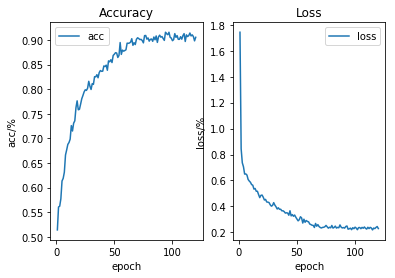

In [52]:
import matplotlib.pyplot as plt

epoch = list(range(1, 121))
plt.subplot(1, 2, 1)
plt.plot(epoch, history.history['acc'], label="acc")
plt.title("Accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc/%")


plt.subplot(1, 2, 2)
plt.plot(epoch, history.history['loss'], label="loss")
plt.title("Loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss/%")

plt.show()